In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import linregress
np.random.seed(1265)
from functools import reduce
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon, Polygon
from shapely.ops import unary_union
import os

###Machine Learning
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

##Supervised Learning
from sklearn.model_selection import cross_validate, KFold
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##Deep learning session
import tensorflow as tf
from keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adagrad

np.random.seed(123)
tf.random.set_seed(123)

# Study of Properties (Clean)

In [2]:
string_brackets_columns = ['resoFacts.patioAndPorchFeatures', 'resoFacts.waterSource', 'resoFacts.exteriorFeatures',
                           'resoFacts.interiorFeatures', 'resoFacts.communityFeatures', 'resoFacts.constructionMaterials',
                           'resoFacts.foundationDetails', 'resoFacts.utilities', 'resoFacts.appliances', 
                           'resoFacts.flooring', 'resoFacts.parkingFeatures',
                           'resoFacts.lotFeatures', 'resoFacts.fireplaceFeatures', 'resoFacts.laundryFeatures', 
                           'resoFacts.propertySubType', 'resoFacts.securityFeatures', 
                           'resoFacts.cooling', 'resoFacts.windowFeatures', 'resoFacts.heating', 'resoFacts.sewer', 
                           'resoFacts.poolFeatures']

string_comma_columns = ['resoFacts.architecturalStyle', 
                        'resoFacts.fencing', 'resoFacts.roofType']

t = string_brackets_columns + string_comma_columns
Selected_features = list(set(t) - set(['resoFacts.utilities', 'resoFacts.propertySubType']))

Year_list2022 = ['2022']
Month_list2022 = ['July', 'August', 'September', 'October', 'November', 'December']
Year_list2023 = ['2023']
Month_list2023 = ['January', 'February', 'March']

##This is a dictionary that stores the original data everymonth
original_data = dict()

##This is a dictionary that store the datasets for every month
monthly_data_dict1 = dict()

##This is a dictionary that store datasets to run analysis
monthly_data_dict2 = dict()
path_abs = "C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Houses_categorical_property\\"

##Remove zipcode, city, county, SchoolDistrict since longitude and latitude will do the part

def read_house_data(Monthlist, Yearlist, original_data, monthly_data_dict1, monthly_data_dict2):
    for Year in Yearlist:
        for Month in Monthlist:
            main_df = pd.read_csv("C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Clean_data_House_properties\\" + Month + '_' + Year + '\\houses_properties_' + Month + '.csv')
            cols = main_df.columns.tolist()

            ##Rename some columns
            for c in cols:
                if 'resoFacts.' in c:
                    feature = c.split('.')[1]
                    main_df[feature] = main_df[c]
                    main_df.drop(labels = [c], axis = 1, inplace = True)

            ##Drop unimportant features 
            main_df.drop(labels = ['streetAddress', 'countyId', 'hasCooling', 'hasHeating'], axis = 1, inplace = True)
            main_df.reset_index(drop = True, inplace = True)

            ##Join the categorical dataframes
            for category in Selected_features:
                ft = category.split('.')[1]
                name = 'houses' + '_' + ft + '.csv'
                df_cat = pd.read_csv(path_abs + Month + '_' + Year + '\\' + name)
                main_df = pd.merge(main_df, df_cat, how = 'left', on = 'zpid')

            string_list = ['city', 'county', 'SchoolDistrict', 'levels']
            for string in string_list:
                main_df[string] = main_df[string].str.lower()
            original_data[Month + '_' + Year] = main_df

            ##Need the zpid (zillow id) to keep track of the data
            #main_df.drop(labels = ['zpid'], axis = 1, inplace = True)
            monthly_data_dict1[Month + '_' + Year] = main_df

            remove_features = ['zipcode', 'city', 'SchoolDistrict', 'annualHomeownersInsurance']
            main_df2 = main_df.copy()
            main_df2.drop(labels = remove_features, axis = 1, inplace = True)
            monthly_data_dict2[Month + '_' + Year] = main_df2

In [3]:
read_house_data(Month_list2022, Year_list2022, original_data, monthly_data_dict1, monthly_data_dict2)
read_house_data(Month_list2023, Year_list2023, original_data, monthly_data_dict1, monthly_data_dict2)

In [4]:
for Month, df in monthly_data_dict1.items():
    monthly_data_dict1[Month]['zipcode'] = monthly_data_dict1[Month]['zipcode'].astype('int64')

In [6]:
for Month, df in monthly_data_dict1.items():
    monthly_data_dict1[Month]['price/livingsqft'] = monthly_data_dict1[Month]['price'] / monthly_data_dict1[Month]['livingAreaValue']
    monthly_data_dict1[Month]['price/lotsqft'] = monthly_data_dict1[Month]['price'] / monthly_data_dict1[Month]['lotArea']
    monthly_data_dict1[Month]['liv/lot_ratio'] = monthly_data_dict1[Month]['livingAreaValue'] / monthly_data_dict1[Month]['lotArea']
    
    ###Dividing the price by $100k and living Area by 1000 sqft
    ###What if the we only we the price of the living area only
    ###living_price = (living/lot) * price if liv/lot_ratio < 1 else = price
    monthly_data_dict1[Month]['living_price'] = df.apply(lambda row: row['price'] if row['liv/lot_ratio'] >= 1 else row['liv/lot_ratio']*row['price'], axis=1)
    levels_df = pd.get_dummies(monthly_data_dict1[Month]['levels'], prefix = 'levels')
    df = pd.concat([df.copy(), levels_df], axis=1)
    df = df.copy().drop('levels', axis = 1)
    df = df.copy().drop(df[(df['lotArea'] == 0) | (df['price/lotsqft'] > 1000) | (df['liv/lot_ratio'] > 2)
                           | (df['lotArea'] > 100000)].index)
    monthly_data_dict1[Month] = df

### Checking all the features to keep the same features for all the months

In [7]:

all_columns = set().union(*(df.columns for month, df in monthly_data_dict1.items()))

# check if each dataframe has the same columns
for month, df in monthly_data_dict1.items():
    if set(df.columns) != all_columns:
        # print out which columns are missing
        missing_cols = all_columns - set(df.columns)
        print("Missing columns: ")
        print(sorted(missing_cols))
        print()

Missing columns: 
['architecturalStyle_ranch', 'communityFeatures_fishing', 'communityFeatures_fitnesscenter', 'cooling_heatpump', 'fencing_privacy', 'interiorFeatures_wiredfordata', 'parkingFeatures_directaccess', 'parkingFeatures_enclosed', 'parkingFeatures_kitchenlevel', 'roofType_asphalt', 'waterSource_co-opwater', 'waterSource_mudwater', 'waterSource_well']

Missing columns: 
['architecturalStyle_ranch', 'communityFeatures_fishing', 'communityFeatures_fitnesscenter', 'cooling_heatpump', 'fencing_privacy', 'interiorFeatures_wiredfordata', 'parkingFeatures_directaccess', 'parkingFeatures_enclosed', 'parkingFeatures_kitchenlevel', 'waterSource_co-opwater', 'waterSource_mudwater', 'waterSource_well']

Missing columns: 
['architecturalStyle_ranch', 'communityFeatures_fishing', 'communityFeatures_fitnesscenter', 'cooling_heatpump', 'fireplaceFeatures_electric', 'interiorFeatures_wiredfordata', 'parkingFeatures_enclosed', 'parkingFeatures_kitchenlevel', 'waterSource_co-opwater', 'waterSo

In [8]:
###Let's work on the February data again
df_feb2023 = monthly_data_dict1['February_2023']
df_feb2023

,zpid,annualHomeownersInsurance,monthlyHoaFee,livingAreaValue,bedrooms,longitude,latitude,zipcode,city,mortgageRates.fifteenYearFixedRate,...,laundryFeatures_other,price/livingsqft,price/lotsqft,liv/lot_ratio,living_price,levels_multi/split,levels_one,levels_one and one half,levels_three or more,levels_two
0,7.894782e+07,567.0,0.0,1480.0,3.0,-97.696070,33.361850,76225,alvord,6.250,...,0,91.148649,12.003403,0.131690,17765.035841,0,1,0,0,0
1,2.399566e+08,735.0,0.0,1620.0,5.0,-97.439285,33.164368,76234,decatur,6.250,...,0,108.024691,2.509336,0.023229,4065.124586,0,1,0,0,0
2,7.893851e+07,832.0,0.0,1197.0,3.0,-97.565500,33.076668,76023,boyd,6.250,...,1,165.413534,28.232637,0.170679,33794.466403,0,1,0,0,0
3,7.894306e+07,714.0,0.0,1064.0,2.0,-97.807000,33.292140,76431,chico,6.250,...,0,159.680451,9.513091,0.059576,10121.928823,0,1,0,0,0
4,2.526456e+08,1239.0,0.0,1428.0,3.0,-97.499040,33.009575,76071,newark,5.781,...,0,206.582633,2.983378,0.014442,4260.263832,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11192,3.054971e+08,3486.0,35.0,4303.0,4.0,-96.781555,32.527160,75154,red oak,5.618,...,0,192.888682,22.819375,0.118303,98191.770729,0,1,0,0,0
11194,1.223067e+08,3696.0,29.0,3227.0,4.0,-96.915016,32.517906,76065,midlothian,5.618,...,0,272.699101,11.051433,0.040526,35662.975488,0,0,1,0,0
11200,3.312331e+08,5208.0,0.0,4681.0,4.0,-96.840440,32.348778,75165,waxahachie,5.868,...,0,264.900662,28.466483,0.107461,133251.606979,0,0,0,0,1
11201,2.066871e+09,3780.0,63.0,4300.0,4.0,-96.842514,32.539078,75154,red oak,5.618,...,0,209.279070,26.485720,0.126557,113888.594570,0,0,0,0,1


In [9]:
df_feb2023.columns.tolist()

['zpid',
 'annualHomeownersInsurance',
 'monthlyHoaFee',
 'livingAreaValue',
 'bedrooms',
 'longitude',
 'latitude',
 'zipcode',
 'city',
 'mortgageRates.fifteenYearFixedRate',
 'mortgageRates.thirtyYearFixedRate',
 'mortgageRates.arm5Rate',
 'propertyTaxRate',
 'price',
 'county',
 'lotArea',
 'SchoolDistrict',
 'Crime_per_1000',
 'isSeniorCommunity',
 'hasAssociation',
 'hasPrivatePool',
 'canRaiseHorses',
 'hasGarage',
 'hasAttachedGarage',
 'hasCarport',
 'carportSpaces',
 'garageSpaces',
 'parking',
 'hasSpa',
 'coveredSpaces',
 'bathrooms',
 'bathroomsHalf',
 'bathroomsFull',
 'hasFireplace',
 'fireplaces',
 'isNewConstruction',
 'lotFeatures_lrg.backyardgrass',
 'lotFeatures_acreage',
 'lotFeatures_cornerlot',
 'lotFeatures_fewtrees',
 'lotFeatures_none',
 'lotFeatures_interiorlot',
 'lotFeatures_subdivided',
 'lotFeatures_cul-de-sac',
 'lotFeatures_landscaped',
 'lotFeatures_sprinklersystem',
 'lotFeatures_other',
 'lotFeatures_manytrees',
 'constructionMaterials_siding',
 'con

In [10]:
##Need to categorize levels
True_False_features = ['isSeniorCommunity', 'hasAssociation', 'hasPrivatePool', 'hasGarage',
                       'hasAttachedGarage', 'hasCarport', 'hasSpa', 'hasFireplace', 'isNewConstruction']

Numerical_features = ['monthlyHoaFee', 'liv/lot_ratio', 'bedrooms', 'carportSpaces', 'garageSpaces', 
                      'coveredSpaces', 'parking', 'bathroomsHalf', 'bathroomsFull', 'fireplaces']

##levels, laundry features, flooring features, construction features, exterior features, interior features, appliances,
##foundations, lotFeatures, securityFeatures, sewer of the house.

Categorical_features = ['levels_one', 'levels_one and one half', 'levels_two', 'levels_three or more',
                        'levels_multi/split', 'laundryFeatures_none', 'laundryFeatures_electricdryerhookup',
                        'laundryFeatures_fullsizew/darea', 'laundryFeatures_washerhookup', 'laundryFeatures_utilityroom',
                        'laundryFeatures_other', 'flooring_carpet', 'flooring_laminate', 'flooring_vinyl',
                        'flooring_ceramictile', 'flooring_hardwood', 'flooring_other', 'flooring_luxuryvinylplank',
                        'flooring_tile', 'flooring_wood', 'constructionMaterials_siding', 'constructionMaterials_wood',
                        'constructionMaterials_brick', 'constructionMaterials_other', 'constructionMaterials_frame',
                        'constructionMaterials_fibercement', 'constructionMaterials_rock/stone', 'exteriorFeatures_coveredpatio/porch',
                        'exteriorFeatures_storage', 'exteriorFeatures_other', 'exteriorFeatures_raingutters',
                        'exteriorFeatures_lighting', 'exteriorFeatures_privateyard', 'interiorFeatures_granitecounters',
                        'interiorFeatures_highspeedinternetavailable', 'interiorFeatures_other', 'interiorFeatures_cabletvavailable',
                        'interiorFeatures_eat-inkitchen', 'interiorFeatures_pantry', 'interiorFeatures_openfloorplan',
                        'interiorFeatures_kitchenisland', 'interiorFeatures_vaultedceiling(s)', 
                        'interiorFeatures_walk-incloset(s)', 'interiorFeatures_built-infeatures', 'interiorFeatures_decorativelighting',
                        'interiorFeatures_smarthomesystem', 'interiorFeatures_doublevanity', 'interiorFeatures_flatscreenwiring',
                        'interiorFeatures_chandelier', 'interiorFeatures_soundsystemwiring', 'interiorFeatures_wetbar',
                        'appliances_electricrange', 'appliances_refrigerator', 'appliances_gasrange', 'appliances_dishwasher',
                        'appliances_gasoven', 'appliances_gaswaterheater', 'appliances_electricoven', 'appliances_microwave',
                        'appliances_electriccooktop', 'appliances_electricwaterheater', 'appliances_ventedexhaustfan',
                        'appliances_disposal', 'appliances_plumbedforgasinkitchen', 'appliances_tanklesswaterheater',
                        'appliances_gascooktop', 'appliances_doubleoven', 'appliances_convectionoven', 'appliances_built-ingasrange', 
                        'appliances_other', 'foundationDetails_pillar/post/pier', 'foundationDetails_slab',
                        'foundationDetails_other', 'lotFeatures_lrg.backyardgrass', 'lotFeatures_acreage',
                        'lotFeatures_cornerlot', 'lotFeatures_fewtrees', 'lotFeatures_none', 'lotFeatures_interiorlot',
                        'lotFeatures_subdivided', 'lotFeatures_cul-de-sac', 'lotFeatures_landscaped',
                        'lotFeatures_sprinklersystem', 'lotFeatures_other', 'lotFeatures_manytrees',
                        'securityFeatures_none', 'securityFeatures_smokedetector(s)', 'securityFeatures_carbonmonoxidedetector(s)',
                        'securityFeatures_firealarm', 'securityFeatures_securitysystem',
                        'securityFeatures_securitysystemowned', 'securityFeatures_burglar', 'securityFeatures_prewired',
                        'securityFeatures_other', 'sewer_citysewer', 'sewer_aerobicseptic', 'sewer_septic',
                        'sewer_other']

In [11]:
###Ensure that all of the dataframes have the same number of features
for month, df in monthly_data_dict1.items():
    set1 = set(Categorical_features)
    set2 = set(df.columns.tolist())
    print(len(Categorical_features) <= len(df.columns.tolist()) and set1 <= set2)

True
True
True
True
True
True
True
True
True


In [12]:
###We have 94 consistent features that describe a home
len(True_False_features + Numerical_features + Categorical_features)

117

In [13]:
print("Number of True or False features: ", len(True_False_features))
print("Number of Numerical features: ", len(Numerical_features))
print("Number of Categorical features: ", len(Categorical_features))

Number of True or False features:  9
Number of Numerical features:  10
Number of Categorical features:  98


### LivingAreaValue/1000 vs. price/100k

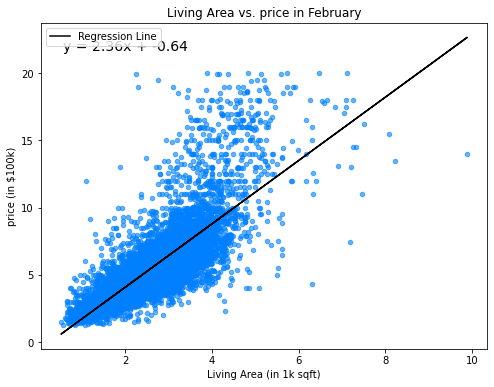

In [14]:
x = df_feb2023['livingAreaValue']/1000
y = df_feb2023['price']/100000

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, marker='o', color = (0, 0.5, 1), alpha = 0.6, s=20)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
ax.plot(x, slope * x + intercept, color='black', label='Regression Line')
ax.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
plt.title('Living Area vs. price in February')
plt.xlabel('Living Area (in 1k sqft)')
plt.ylabel('price (in $100k)')
ax.legend()
plt.show()

In [15]:
df_feb2023[['livingAreaValue', 'price']].corr()

,livingAreaValue,price
livingAreaValue,1.000000,0.793663
price,0.793663,1.000000


<AxesSubplot: >

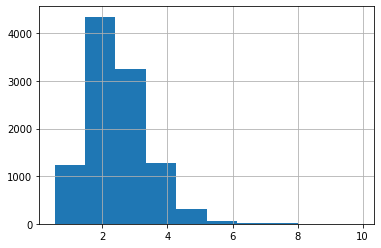

In [16]:
(df_feb2023['livingAreaValue']/1000).hist()

<AxesSubplot: >

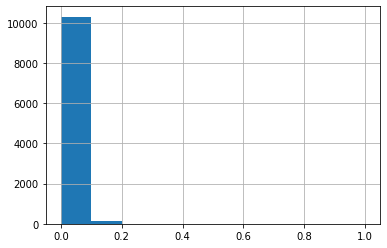

In [17]:
(df_feb2023['monthlyHoaFee']/df_feb2023['monthlyHoaFee'].max()).hist()

### liv/lot_ratio vs. price/100k

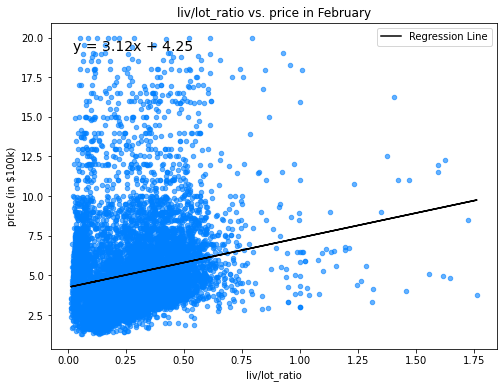

In [18]:
x = df_feb2023['liv/lot_ratio']
y = df_feb2023['price']/100000

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, marker='o', color = (0, 0.5, 1), alpha = 0.6, s=20)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
ax.plot(x, slope * x + intercept, color='black', label='Regression Line')
ax.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
plt.title('liv/lot_ratio vs. price in February')
plt.xlabel('liv/lot_ratio')
plt.ylabel('price (in $100k)')
ax.legend()
plt.show()

In [19]:
df_feb2023[['liv/lot_ratio', 'price']].corr()

,liv/lot_ratio,price
liv/lot_ratio,1.000000,0.190347
price,0.190347,1.000000


### liv/lot_ratio vs. living_price

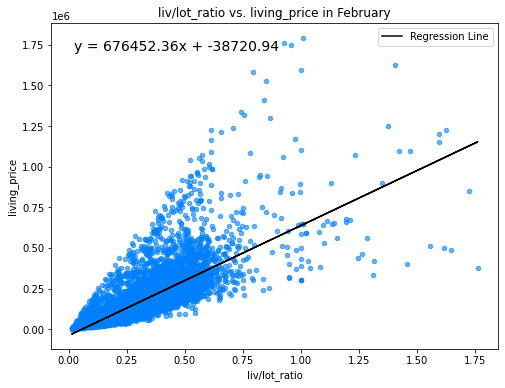

In [20]:
x = df_feb2023['liv/lot_ratio']
y = df_feb2023['living_price']

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, marker='o', color = (0, 0.5, 1), alpha = 0.6, s=20)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
ax.plot(x, slope * x + intercept, color='black', label='Regression Line')
ax.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
plt.title('liv/lot_ratio vs. living_price in February')
plt.xlabel('liv/lot_ratio')
plt.ylabel('living_price')
ax.legend()
plt.show()

<AxesSubplot: >

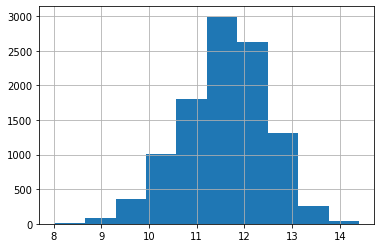

In [21]:
np.log(df_feb2023['living_price']).hist()

In [22]:
df_feb2023[Numerical_features + ['living_price', 'price']].corr()[['living_price', 'price']]

,living_price,price
monthlyHoaFee,0.382558,0.300639
liv/lot_ratio,0.765995,0.190347
bedrooms,0.300473,0.349609
carportSpaces,-0.080747,-0.010732
garageSpaces,0.248793,0.458163
coveredSpaces,0.192593,0.407973
parking,0.192593,0.407973
bathroomsHalf,0.330371,0.372430
bathroomsFull,0.562443,0.687126
fireplaces,0.197127,0.466935


### Applying PCA to categorical features

In [21]:
len(Categorical_features)

98

In [22]:
pca = PCA(n_components = 50, random_state = 0)
df_t = df_feb2023[Categorical_features].copy()
df_t = pca.fit_transform(X = df_t)

In [23]:
df_PCA = pd.DataFrame(df_t, columns = ['PCA' + str(i+1) for i in range(50)])
df_PCA

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49,PCA50
0,-2.303576,-0.313484,-0.614997,-0.212838,0.082890,0.810547,-0.074710,0.707919,-0.212351,0.483577,...,-0.371156,-0.030257,-0.087508,-0.209599,0.130868,-0.131923,-0.210059,-0.092282,-0.137870,-0.069642
1,-2.278202,-0.492585,-0.680033,0.711681,0.447137,1.606933,0.104473,-0.300242,-0.173810,1.031334,...,-0.364379,0.279278,-0.086268,0.379197,-0.527166,0.176206,-0.354293,0.191567,-0.163989,0.556767
2,-2.016420,-1.501434,-1.043728,0.107265,-1.152049,0.995274,-0.253455,0.178795,0.444746,-0.440303,...,-0.111099,0.097309,0.094811,0.169753,0.234278,0.078366,0.249836,-0.107509,0.124488,-0.130560
3,-1.974647,-1.023627,-1.216427,0.379398,-0.556445,1.247189,0.010157,0.179770,0.919006,-0.047888,...,0.021556,-0.164849,-0.426151,0.218680,-0.003387,-0.400753,-0.346493,-0.143667,-0.331606,0.210346
4,-2.038375,-0.585039,-0.038257,0.067215,0.694017,1.348017,-0.445413,-0.216543,0.585630,0.259195,...,0.291490,-0.103281,-0.683481,0.391764,-0.216479,-0.350062,-0.041649,0.319276,-0.432801,-0.063577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11012,-1.368828,-0.430750,-0.779657,1.043953,0.567894,1.394564,0.577571,-0.518339,-0.164872,0.395884,...,0.418798,0.517172,-0.264404,0.302334,-0.186849,0.554361,0.253060,-0.131754,-0.310789,0.171382
11013,-2.007110,0.464704,0.478894,0.553554,-0.238077,-0.499792,0.063740,0.034962,0.160068,0.280786,...,-0.528547,-0.444727,-0.149579,0.792167,-0.144109,0.138294,-0.276927,-0.059160,0.409448,-0.160667
11014,-2.548490,-0.068003,0.666897,1.087953,-0.234394,1.118614,0.222508,-0.024586,0.602407,0.395038,...,-0.280121,-0.293480,-0.008119,-0.257351,0.030438,-0.219426,-0.203185,0.011547,-0.390194,-0.069174
11015,0.504964,-0.835310,0.328419,-0.789052,0.581575,0.136052,-0.042457,-0.597847,0.170444,0.685333,...,-0.089786,-0.010407,0.388705,0.337487,0.147107,0.120092,-0.305247,0.469782,0.405826,-0.077534


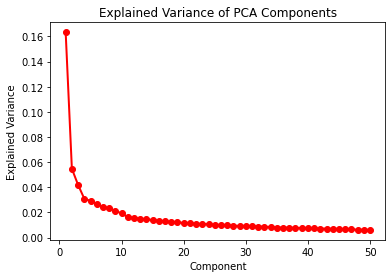

In [24]:
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance of each component
plt.plot(np.arange(1, len(explained_variance)+1), explained_variance, 'ro-', linewidth=2)
plt.title('Explained Variance of PCA Components')
plt.xlabel('Component')
plt.ylabel('Explained Variance')
plt.show()

In [25]:
sum(pca.explained_variance_ratio_)
###Apply some kind of dimensionality reduction for the deep learning model

0.8222513033008958

#### ML with this dataset (February)

In [12]:
###Transform all the data so that it can be used with ML
def transform_data(df, True_False_features, Numerical_features, Categorical_features):
    df_transformed = df.copy()
    for ft in True_False_features:
        df_transformed.loc[df_transformed[ft] == True, ft] = 1
        df_transformed.loc[df_transformed[ft] == False, ft] = 0
        df_transformed[ft] = df_transformed[ft].astype(int)
    return df_transformed[True_False_features + Numerical_features + Categorical_features + ['living_price']]

In [27]:
df_feb2023_ml = transform_data(df_feb2023, True_False_features, Numerical_features, Categorical_features)
df_feb2023_ml

,isSeniorCommunity,hasAssociation,hasPrivatePool,hasGarage,hasAttachedGarage,hasCarport,hasSpa,hasFireplace,isNewConstruction,monthlyHoaFee,...,securityFeatures_securitysystem,securityFeatures_securitysystemowned,securityFeatures_burglar,securityFeatures_prewired,securityFeatures_other,sewer_citysewer,sewer_aerobicseptic,sewer_septic,sewer_other,living_price
0,0,0,0,1,1,0,0,0,0,0.0,...,0,0,0,0,0,1,0,0,0,17765.035841
1,0,0,0,0,0,0,0,0,0,0.0,...,0,0,0,0,1,0,1,0,0,4065.124586
2,0,0,0,0,0,1,0,0,0,0.0,...,0,0,0,0,0,1,0,0,0,33794.466403
3,0,0,0,0,0,1,0,0,0,0.0,...,0,0,0,0,0,1,0,0,0,10121.928823
4,0,0,0,0,0,0,0,1,0,0.0,...,0,0,0,0,0,0,0,1,0,4260.263832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11199,0,0,0,1,0,0,0,0,1,0.0,...,1,0,0,0,1,0,0,0,1,909.846016
11200,0,0,0,1,1,0,0,1,0,0.0,...,0,0,0,0,0,0,1,0,0,133251.606979
11201,0,1,1,1,1,0,0,1,1,63.0,...,0,0,0,0,0,0,0,1,0,113888.594570
11202,0,1,0,1,1,0,0,1,1,24.0,...,0,0,0,0,0,1,0,0,0,98145.645708


In [28]:
df_feb2023_ml['isSeniorCommunity'].dtypes

dtype('int32')

In [13]:
###This function scale the data with properties
##Add pca transformation in here to test out the results
##pca_on represents if you want to use pca on the categorical variables

def prep_data_properties(splits, scaler, df_model, Numerical_features):
    data = df_model.to_numpy()
    cv = KFold(n_splits = splits, shuffle = True, random_state = 0)
    cv.split(data)

    train_set_dict = dict()
    train_target_dict = dict()
    scaled_train_set = dict()
    scaled_train_target = dict()

    test_set_dict = dict()
    test_target_dict = dict()
    scaled_test_set = dict()
    scaled_test_target = dict()

    ###Store K folds data into dictionary
    for i, (train_index, test_index) in enumerate(cv.split(data)):
        train_set = df_model.iloc[train_index].iloc[:, :-1]
        train_target = df_model.iloc[train_index].iloc[:, -1]
        train_set_dict['Fold ' + str(i)] = train_set.copy()
        train_target_dict['Fold ' + str(i)] = train_target.copy()

        test_set = df_model.iloc[test_index].iloc[:, :-1]
        test_target = df_model.iloc[test_index].iloc[:, -1]
        test_set_dict['Fold ' + str(i)] = test_set.copy()
        test_target_dict['Fold ' + str(i)] = test_target.copy()
        
        ###This was designed to scale the numerical features of train and test set
        the_scaler = scaler
        scaled_train = train_set.copy()
        scaled_test = test_set.copy()
        num_transformer = ColumnTransformer(transformers=[('num', MinMaxScaler(), Numerical_features)])
        scaled_train[Numerical_features] = num_transformer.fit_transform(train_set.copy()[Numerical_features])
        scaled_test[Numerical_features] = num_transformer.transform(test_set.copy()[Numerical_features])
        
        ###This was desinged to scale the categorical features of train and test set
        #if pca_on == True:
            #n_c = 50
            #pca = PCA(n_components = n_c, random_state = 0)
            #train_categories = train_set.copy()[Categorical_features]
            #test_categories = test_set.copy()[Categorical_features]
            #train = pca.fit_transform(X = train_categories)
            #test = pca.transfrorm(X = test_categories)
            #scaled_train_categories = pd.DataFrame(train, columns = ['PCA' + str(i+1) for i in range(n_c)])
            #scaled_test_categories = pd.DataFrame(test, columns = ['PCA' + str(i+1) for i in range(n_c)])
            
        scaled_train_set['Fold ' + str(i)] = scaled_train
        scaled_train_target['Fold ' + str(i)] = np.log(train_target_dict['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        scaled_test_set['Fold ' + str(i)] = scaled_test
        scaled_test_target['Fold ' + str(i)] = np.log(test_target_dict['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        
    return (train_set_dict, train_target_dict, scaled_train_set, scaled_train_target,
            test_set_dict, test_target_dict, scaled_test_set, scaled_test_target)

In [30]:
splits = 5
scaler = MinMaxScaler()
all_dicts = prep_data_properties(splits, scaler, df_feb2023_ml, Numerical_features)
train_set = all_dicts[0]
train_target = all_dicts[1]
scaled_train_set = all_dicts[2]
scaled_train_target = all_dicts[3]

test_set = all_dicts[4]
test_target = all_dicts[5]
scaled_test_set = all_dicts[6]
scaled_test_target = all_dicts[7]

In [31]:
scaled_train_set['Fold 1'][Numerical_features]

,monthlyHoaFee,liv/lot_ratio,bedrooms,carportSpaces,garageSpaces,coveredSpaces,parking,bathroomsHalf,bathroomsFull,fireplaces
0,0.0000,0.074423,0.046512,0.000,0.083333,0.0625,0.0625,0.000000,0.250,0.000000
1,0.0000,0.012834,0.093023,0.000,0.000000,0.0000,0.0000,0.000000,0.250,0.000000
2,0.0000,0.096562,0.046512,0.125,0.000000,0.0625,0.0625,0.000000,0.250,0.000000
3,0.0000,0.033473,0.023256,0.250,0.000000,0.1250,0.1250,0.000000,0.250,0.000000
4,0.0000,0.007844,0.046512,0.000,0.000000,0.0000,0.0000,0.000000,0.125,0.166667
...,...,...,...,...,...,...,...,...,...,...
11199,0.0000,0.000171,0.023256,0.000,0.083333,0.0625,0.0625,0.000000,0.125,0.000000
11200,0.0000,0.060664,0.069767,0.000,0.250000,0.1875,0.1875,0.333333,0.375,0.166667
11201,0.0315,0.071508,0.069767,0.000,0.166667,0.1250,0.1250,0.333333,0.375,0.166667
11202,0.0120,0.056804,0.069767,0.000,0.250000,0.1875,0.1875,0.333333,0.375,0.166667


In [32]:
scaled_train_set['Fold 0'].to_numpy().shape

(8813, 117)

In [14]:
def properties_ml(model, train_set_dict, train_target_dict, test_set_dict, test_target_dict, verbose = 0):
    Test_R2_list = list()
    Test_adjusted_R2_list = list()
    Train_R2_list = list()
    rmse_list = list()
    mae_list = list()

    for i in range(5):
        train_set = train_set_dict['Fold ' + str(i)]
        train_target = train_target_dict['Fold ' + str(i)].to_numpy()
        test_set = test_set_dict['Fold ' + str(i)]
        test_target = test_target_dict['Fold ' + str(i)].to_numpy()
        model.fit(train_set, train_target)
        train_r_squared = model.score(train_set, train_target)
        
        test_observed = test_target_dict['Fold ' + str(i)].to_numpy().reshape(-1, 1)
        test_predicted = model.predict(test_set)
        r2 = r2_score(test_observed, test_predicted)
        n = test_observed.shape[0]
        p = train_set.shape[1]
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
        mse = mean_squared_error(test_observed, test_predicted)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test_observed, test_predicted)

        Test_R2_list.append(r2)
        Test_adjusted_R2_list.append(adjusted_r2)
        Train_R2_list.append(train_r_squared)
        rmse_list.append(rmse)
        mae_list.append(mae)
        
        if verbose == 1:
            print("Fold " + str(i + 1) + " Test R-squared score:", np.round(r2, 4))
            print("Fold " + str(i + 1) + " Test Adjusted R-squared score:", np.round(adjusted_r2, 4))
            print("Fold " + str(i + 1) + " RMSE:", np.round(rmse, 4))
            print("Fold " + str(i + 1) + " MAE:", np.round(mae, 4))
            print()
    dif = np.round(sum(Train_R2_list)/len(Train_R2_list), 4) - np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
    dif = np.round(dif * 100, 2)
    if verbose == 1:
        print("The average Train R-squared : ", np.round(sum(Train_R2_list)/len(Train_R2_list), 4))
        print("The average Test R-squared : ", np.round(sum(Test_R2_list)/len(Test_R2_list), 4))
        print("The average Test adjusted R-squared: ", np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4))
        print("The average deviation from actual value (RMSE): ", np.round(sum(rmse_list)/len(rmse_list), 4))
        print("The average deviation from actual value (MAE): ", np.round(sum(mae_list)/len(mae_list), 4))
        print("Difference between Train vs. Test R-squared: ", dif, "%")
    avg_Train_R2 = np.round(sum(Train_R2_list)/len(Train_R2_list), 4)
    avg_Test_R2 = np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
    avg_Test_adjusted_R2 = np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4)
    avg_Test_RMSE = np.round(sum(rmse_list)/len(rmse_list), 4)
    avg_Test_MAE = np.round(sum(mae_list)/len(mae_list), 4)
    return (avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif)

In [34]:
RF = RandomForestRegressor()
avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif = properties_ml(RF, train_set, train_target, test_set, test_target, verbose = 1)

Fold 1 Test R-squared score: 0.8966
Fold 1 Test Adjusted R-squared score: 0.8908
Fold 1 RMSE: 44487.0803
Fold 1 MAE: 22469.8902

Fold 2 Test R-squared score: 0.8792
Fold 2 Test Adjusted R-squared score: 0.8724
Fold 2 RMSE: 50197.7312
Fold 2 MAE: 24931.4608

Fold 3 Test R-squared score: 0.8729
Fold 3 Test Adjusted R-squared score: 0.8657
Fold 3 RMSE: 48496.1271
Fold 3 MAE: 24346.6646

Fold 4 Test R-squared score: 0.8838
Fold 4 Test Adjusted R-squared score: 0.8772
Fold 4 RMSE: 51938.4522
Fold 4 MAE: 24652.8472

Fold 5 Test R-squared score: 0.8635
Fold 5 Test Adjusted R-squared score: 0.8558
Fold 5 RMSE: 57473.6295
Fold 5 MAE: 25318.3857

The average Train R-squared :  0.9833
The average Test R-squared :  0.8792
The average Test adjusted R-squared:  0.8724
The average deviation from actual value (RMSE):  50518.6041
The average deviation from actual value (MAE):  24343.8497
Difference between Train vs. Test R-squared:  10.41 %


In [35]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif = properties_ml(xg_reg, train_set, train_target, test_set, test_target, verbose = 1)

Fold 1 Test R-squared score: 0.8796
Fold 1 Test Adjusted R-squared score: 0.8729
Fold 1 RMSE: 48001.277
Fold 1 MAE: 23192.8124

Fold 2 Test R-squared score: 0.8839
Fold 2 Test Adjusted R-squared score: 0.8774
Fold 2 RMSE: 49193.1844
Fold 2 MAE: 24858.9862

Fold 3 Test R-squared score: 0.8687
Fold 3 Test Adjusted R-squared score: 0.8614
Fold 3 RMSE: 49274.1524
Fold 3 MAE: 24312.1876

Fold 4 Test R-squared score: 0.8986
Fold 4 Test Adjusted R-squared score: 0.8929
Fold 4 RMSE: 48502.6055
Fold 4 MAE: 24511.7718

Fold 5 Test R-squared score: 0.8914
Fold 5 Test Adjusted R-squared score: 0.8853
Fold 5 RMSE: 51262.693
Fold 5 MAE: 23774.5049

The average Train R-squared :  0.9914
The average Test R-squared :  0.8845
The average Test adjusted R-squared:  0.878
The average deviation from actual value (RMSE):  49246.7825
The average deviation from actual value (MAE):  24130.0526
Difference between Train vs. Test R-squared:  10.69 %


In [36]:
HGBR = HistGradientBoostingRegressor()
avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif = properties_ml(HGBR, train_set, train_target, test_set, test_target, verbose = 1)

Fold 1 Test R-squared score: 0.8991
Fold 1 Test Adjusted R-squared score: 0.8935
Fold 1 RMSE: 43936.5051
Fold 1 MAE: 22372.0864

Fold 2 Test R-squared score: 0.8888
Fold 2 Test Adjusted R-squared score: 0.8825
Fold 2 RMSE: 48162.449
Fold 2 MAE: 24045.9121

Fold 3 Test R-squared score: 0.8694
Fold 3 Test Adjusted R-squared score: 0.862
Fold 3 RMSE: 49154.08
Fold 3 MAE: 24116.4977

Fold 4 Test R-squared score: 0.9025
Fold 4 Test Adjusted R-squared score: 0.8971
Fold 4 RMSE: 47559.5703
Fold 4 MAE: 23550.49

Fold 5 Test R-squared score: 0.8857
Fold 5 Test Adjusted R-squared score: 0.8793
Fold 5 RMSE: 52581.678
Fold 5 MAE: 23889.1836

The average Train R-squared :  0.9631
The average Test R-squared :  0.8891
The average Test adjusted R-squared:  0.8829
The average deviation from actual value (RMSE):  48278.8565
The average deviation from actual value (MAE):  23594.834
Difference between Train vs. Test R-squared:  7.4 %


##### Tuning the HisGradientBoosting model

In [37]:
HGBR = HistGradientBoostingRegressor(max_iter = 100, l2_regularization = 0.5, tol = 1e-6)
avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif = properties_ml(HGBR, train_set, train_target, test_set, test_target, verbose = 1)

Fold 1 Test R-squared score: 0.9012
Fold 1 Test Adjusted R-squared score: 0.8957
Fold 1 RMSE: 43481.8628
Fold 1 MAE: 22352.6493

Fold 2 Test R-squared score: 0.8914
Fold 2 Test Adjusted R-squared score: 0.8853
Fold 2 RMSE: 47589.5242
Fold 2 MAE: 23959.6788

Fold 3 Test R-squared score: 0.8791
Fold 3 Test Adjusted R-squared score: 0.8723
Fold 3 RMSE: 47286.6783
Fold 3 MAE: 23583.5748

Fold 4 Test R-squared score: 0.9024
Fold 4 Test Adjusted R-squared score: 0.8969
Fold 4 RMSE: 47596.5365
Fold 4 MAE: 23217.3344

Fold 5 Test R-squared score: 0.89
Fold 5 Test Adjusted R-squared score: 0.8839
Fold 5 RMSE: 51582.8813
Fold 5 MAE: 23384.791

The average Train R-squared :  0.9625
The average Test R-squared :  0.8928
The average Test adjusted R-squared:  0.8868
The average deviation from actual value (RMSE):  47507.4966
The average deviation from actual value (MAE):  23299.6057
Difference between Train vs. Test R-squared:  6.97 %


### Deep learning session

In [56]:
df_month = monthly_data_dict1['February_2023']
df_model = transform_data(df_month, True_False_features, Numerical_features, Categorical_features)

splits = 5
scaler = MinMaxScaler()
all_dicts = prep_data_properties(splits, scaler, df_model, Numerical_features)
train_set = all_dicts[0]
train_target = all_dicts[1]
scaled_train_set = all_dicts[2]
scaled_train_target = all_dicts[3]

test_set = all_dicts[4]
test_target = all_dicts[5]
scaled_test_set = all_dicts[6]
scaled_test_target = all_dicts[7]

In [15]:
def ann_properties_generator(input_shape):
    T = input_shape
    i = Input(shape = [T,])
    x = Dense(80)(i)
    x = Activation('relu')(x)
    x = Dense(60)(x)
    x = Activation('relu')(x)
    x = Dense(20)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)
    model = Model(inputs = i, outputs = output)
    
    return model

In [40]:
input_shape = train_set['Fold 0'].shape[1]
model1 = ann_properties_generator(input_shape)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 117)]             0         
                                                                 
 dense (Dense)               (None, 80)                9440      
                                                                 
 activation (Activation)     (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                4860      
                                                                 
 activation_1 (Activation)   (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                1220      
                                                                 
 activation_2 (Activation)   (None, 20)                0     

In [41]:
np.random.seed(123)
tf.random.set_seed(123)

model1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])
check_point = ModelCheckpoint('Properties_ANN_vars/model1_adam_ann.h5', monitor = 'val_mse', save_best_only = True)

Xtrain = scaled_train_set['Fold 0']
ytrain = scaled_train_target['Fold 0']
Xval = scaled_test_set['Fold 0']
yval = scaled_test_target['Fold 0']

result1 = model1.fit(Xtrain, ytrain, epochs = 80, validation_data = (Xval, yval), 
                     batch_size = 32, callbacks = [check_point])

Epoch 1/80
276/276 [==============================] - 3s 8ms/step - loss: 7.5472 - mse: 7.5472 - val_loss: 0.4820 - val_mse: 0.4820
Epoch 2/80
276/276 [==============================] - 2s 7ms/step - loss: 0.6329 - mse: 0.6329 - val_loss: 0.4043 - val_mse: 0.4043
Epoch 3/80
276/276 [==============================] - 2s 8ms/step - loss: 0.5067 - mse: 0.5067 - val_loss: 0.4079 - val_mse: 0.4079
Epoch 4/80
276/276 [==============================] - 2s 8ms/step - loss: 0.4498 - mse: 0.4498 - val_loss: 0.2956 - val_mse: 0.2956
Epoch 5/80
276/276 [==============================] - 2s 8ms/step - loss: 0.4864 - mse: 0.4864 - val_loss: 0.3350 - val_mse: 0.3350
Epoch 6/80
276/276 [==============================] - 2s 8ms/step - loss: 0.4217 - mse: 0.4217 - val_loss: 0.6333 - val_mse: 0.6333
Epoch 7/80
276/276 [==============================] - 2s 9ms/step - loss: 0.3875 - mse: 0.3875 - val_loss: 0.2456 - val_mse: 0.2456
Epoch 8/80
276/276 [==============================] - 2s 9ms/step - loss: 0.

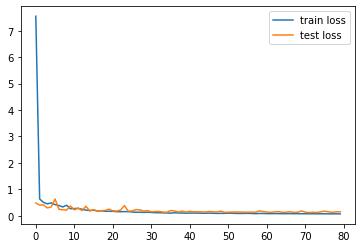

In [42]:
plt.plot(result1.history['loss'], label = 'train loss')
plt.plot(result1.history['val_loss'], label = 'test loss')
plt.legend()

In [43]:
model_allvars = tf.keras.models.load_model("Properties_ANN_vars/model1_adam_ann.h5")
model_allvars.evaluate(Xval, yval)

69/69 [==============================] - 0s 4ms/step - loss: 0.1230 - mse: 0.1230


[0.12299054861068726, 0.12299054861068726]

In [44]:
test_observed = test_target['Fold 0'].to_numpy().reshape(-1, 1)
test_predicted = np.exp(model_allvars.predict(scaled_test_set['Fold 0']))
r2 = r2_score(test_observed, test_predicted)
n = test_observed.shape[0]
p = 9
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

print("Fold " + str(0) + " Test R2 score:", np.round(r2, 4))
print("Fold " + str(0) + " Test Adjusted R2 score:", np.round(adjusted_r2, 4))
print()

Fold 0 Test R2 score: 0.878
Fold 0 Test Adjusted R2 score: 0.8775



In [58]:
###Based on the result above we will use this model architecture
###Apply this on 5-fold cv to consider the result
Test_R2_list = list()
Test_adjusted_R2_list = list()
Train_R2_list = list()
rmse_list = list()
mae_list = list()

np.random.seed(123)
tf.random.set_seed(123)

model = ann_properties_generator(input_shape)
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])

for i in range(5):
    train_set = scaled_train_set['Fold ' + str(i)]
    train_target1 = scaled_train_target['Fold ' + str(i)]
    test_set = scaled_test_set['Fold ' + str(i)]
    test_target1 = scaled_test_target['Fold ' + str(i)]

    check_point = ModelCheckpoint('Properties_ANN_vars/model1_adam_ann_' + 'Fold ' + str(i) + '.h5', 
                                   monitor = 'val_mse', save_best_only = True)
    model.fit(train_set, train_target1, epochs = 80, validation_data = (test_set, test_target1), 
              batch_size = 32, callbacks = [check_point], verbose = 0)
    model_allvars = tf.keras.models.load_model('Properties_ANN_vars/model1_adam_ann_' + 'Fold ' + str(i) + '.h5')
    train_observed = train_target['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    train_predicted = np.exp(model_allvars.predict(train_set))
    train_r_squared = r2_score(train_observed, train_predicted)
        
    test_observed = test_target['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    test_predicted = np.exp(model_allvars.predict(test_set))
    test_r_squared = r2_score(test_observed, test_predicted)
    r2 = r2_score(test_observed, test_predicted)
    n = test_observed.shape[0]
    p = train_set.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    mse = mean_squared_error(test_observed, test_predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_observed, test_predicted)

    Test_R2_list.append(r2)
    Test_adjusted_R2_list.append(adjusted_r2)
    Train_R2_list.append(train_r_squared)
    rmse_list.append(rmse)
    mae_list.append(mae)
    
    print("Fold " + str(i + 1) + " Test R-squared score:", np.round(r2, 4))
    print("Fold " + str(i + 1) + " Test Adjusted R-squared score:", np.round(adjusted_r2, 4))
    print("Fold " + str(i + 1) + " RMSE:", np.round(rmse, 4))
    print("Fold " + str(i + 1) + " MAE:", np.round(mae, 4))
    print()
    
dif = np.round(sum(Train_R2_list)/len(Train_R2_list), 4) - np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
dif = np.round(dif * 100, 2)
print("The average Train R-squared : ", np.round(sum(Train_R2_list)/len(Train_R2_list), 4))
print("The average Test R-squared : ", np.round(sum(Test_R2_list)/len(Test_R2_list), 4))
print("The average Test adjusted R-squared: ", np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4))
print("The average deviation from actual value (RMSE): ", np.round(sum(rmse_list)/len(rmse_list), 4))
print("The average deviation from actual value (MAE): ", np.round(sum(mae_list)/len(mae_list), 4))
print("Difference between Train vs. Test R-squared: ", dif, "%")

Fold 1 Test R-squared score: 0.8773
Fold 1 Test Adjusted R-squared score: 0.8704
Fold 1 RMSE: 48456.511
Fold 1 MAE: 26558.8657

Fold 2 Test R-squared score: 0.8973
Fold 2 Test Adjusted R-squared score: 0.8915
Fold 2 RMSE: 46287.0649
Fold 2 MAE: 22221.4321

Fold 3 Test R-squared score: 0.9456
Fold 3 Test Adjusted R-squared score: 0.9425
Fold 3 RMSE: 31735.9289
Fold 3 MAE: 16975.4971

Fold 4 Test R-squared score: 0.9487
Fold 4 Test Adjusted R-squared score: 0.9458
Fold 4 RMSE: 34500.0707
Fold 4 MAE: 16240.5717

Fold 5 Test R-squared score: 0.9596
Fold 5 Test Adjusted R-squared score: 0.9573
Fold 5 RMSE: 31264.1135
Fold 5 MAE: 14796.7346

The average Train R-squared :  0.9348
The average Test R-squared :  0.9257
The average Test adjusted R-squared:  0.9215
The average deviation from actual value (RMSE):  38448.7378
The average deviation from actual value (MAE):  19358.6202
Difference between Train vs. Test R-squared:  0.91 %


In [16]:
###Based on the result I will pick this architecture for all the monthly location data
###Build a table that stores these results
###First build a function for monthly ANN model to track monthly performance
def properties_ANN(Month, input_shape, scaled_train_set, scaled_train_target, true_train_target, 
                   scaled_test_set, scaled_test_target, true_test_target):
    
    np.random.seed(123)
    tf.random.set_seed(123)
    Test_R2_list = list()
    Test_adjusted_R2_list = list()
    Train_R2_list = list()
    rmse_list = list()
    mae_list = list()

    model = ann_properties_generator(input_shape)
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])
    
    Monthly_path = 'Monthly_properties_ANN/' + Month
    if not os.path.exists(Monthly_path):
        os.makedirs(Monthly_path)
    
    for i in range(5):
        train_set = scaled_train_set['Fold ' + str(i)]
        train_target = scaled_train_target['Fold ' + str(i)]
        test_set = scaled_test_set['Fold ' + str(i)]
        test_target = scaled_test_target['Fold ' + str(i)]
        check_point = ModelCheckpoint(Monthly_path + '/model1_adam_ann_' + 'Fold ' + str(i) + '.h5', 
                                       monitor = 'val_mse', save_best_only = True)
        model.fit(train_set, train_target, epochs = 80, validation_data = (test_set, test_target), 
                  batch_size = 32, callbacks = [check_point], verbose = 0)
        model_allvars = tf.keras.models.load_model(Monthly_path + '/model1_adam_ann_' + 'Fold ' + str(i) + '.h5')
        train_observed = true_train_target['Fold ' + str(i)].to_numpy().reshape(-1, 1)
        train_predicted = np.exp(model_allvars.predict(train_set))
        train_r_squared = r2_score(train_observed, train_predicted)

        test_observed = true_test_target['Fold ' + str(i)].to_numpy().reshape(-1, 1)
        test_predicted = np.exp(model_allvars.predict(test_set))
        test_r_squared = r2_score(test_observed, test_predicted)
        r2 = r2_score(test_observed, test_predicted)
        n = test_observed.shape[0]
        p = train_set.shape[1]
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
        mse = mean_squared_error(test_observed, test_predicted)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test_observed, test_predicted)

        Test_R2_list.append(r2)
        Test_adjusted_R2_list.append(adjusted_r2)
        Train_R2_list.append(train_r_squared)
        rmse_list.append(rmse)
        mae_list.append(mae)
    
    avg_Train_R2 = np.round(sum(Train_R2_list)/len(Train_R2_list), 4)
    avg_Test_R2 = np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
    avg_Test_adjusted_R2 = np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4)
    avg_Test_RMSE = np.round(sum(rmse_list)/len(rmse_list), 4)
    avg_Test_MAE = np.round(sum(mae_list)/len(mae_list), 4)
    dif = np.round(sum(Train_R2_list)/len(Train_R2_list), 4) - np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
    dif = np.round(dif * 100, 2)
    
    month_performance = {Month: [avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif]}
    return month_performance

In [19]:
###Read in all the monthly data and runs both models on these data
Month_list = ['July_2022', 'August_2022', 'September_2022', 'October_2022', 'November_2022',
              'December_2022', 'January_2023', 'February_2023', 'March_2023']
hgbr_performance = dict()
ANN_performance = dict()

HGBR = HistGradientBoostingRegressor(max_iter = 100, l2_regularization = 0.5, tol = 1e-6)

for month in Month_list:
    ###Read in all the datasets
    df_month = monthly_data_dict1[month]
    df_model = transform_data(df_month, True_False_features, Numerical_features, Categorical_features)
    
    ###Prep the data for ML/DL with 5 Folds-cv
    splits = 5
    scaler = MinMaxScaler()
    all_dicts = prep_data_properties(splits, scaler, df_model, Numerical_features)
    train_set = all_dicts[0]
    train_target = all_dicts[1]
    scaled_train_set = all_dicts[2]
    scaled_train_target = all_dicts[3]

    test_set = all_dicts[4]
    test_target = all_dicts[5]
    scaled_test_set = all_dicts[6]
    scaled_test_target = all_dicts[7]
    
    ###Run the ml on data
    avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif = properties_ml(HGBR, train_set, train_target, test_set, test_target, verbose = 0)
    hgbr_performance[month] = [avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif]
    
    ###Run the dl on data
    true_train_target = train_target
    true_test_target = test_target
    input_shape = train_set['Fold 0'].shape[1]
    month_performance = properties_ANN(month, input_shape, scaled_train_set, scaled_train_target, true_train_target, 
                                       scaled_test_set, scaled_test_target, true_test_target)
    ANN_performance.update(month_performance)

In [20]:
hgbr_performance

{'July_2022': [0.9485, 0.8937, 0.8891, 50869.1226, 26707.3764, 5.48],
 'August_2022': [0.9509, 0.8988, 0.8945, 47440.5229, 25387.1775, 5.21],
 'September_2022': [0.954, 0.8928, 0.8875, 46959.2741, 24660.7984, 6.12],
 'October_2022': [0.9549, 0.9015, 0.8975, 45749.1366, 24429.0772, 5.34],
 'November_2022': [0.9509, 0.8975, 0.893, 45243.5017, 24377.2341, 5.34],
 'December_2022': [0.9574, 0.8926, 0.8868, 44574.7876, 23260.7625, 6.48],
 'January_2023': [0.9588, 0.8932, 0.8876, 45972.5737, 23763.5306, 6.56],
 'February_2023': [0.9625, 0.8928, 0.8868, 47507.4966, 23299.6057, 6.97],
 'March_2023': [0.961, 0.8856, 0.8786, 49970.0994, 25011.8199, 7.54]}

In [21]:
ANN_performance

{'July_2022': [0.9434, 0.9269, 0.9237, 39900.2063, 20813.3305, 1.65],
 'August_2022': [0.9461, 0.9117, 0.908, 40979.336, 20482.0482, 3.44],
 'September_2022': [0.9527, 0.9279, 0.9244, 36839.7088, 19317.6908, 2.48],
 'October_2022': [0.9461, 0.9311, 0.9284, 36465.1268, 19078.7209, 1.5],
 'November_2022': [0.9487, 0.9335, 0.9306, 35253.7162, 19134.1506, 1.52],
 'December_2022': [0.9461, 0.9318, 0.9281, 34009.1499, 18309.4377, 1.43],
 'January_2023': [0.9515, 0.9404, 0.9373, 32730.0669, 18056.9726, 1.11],
 'February_2023': [0.9452, 0.9347, 0.931, 35510.6048, 18448.7451, 1.05],
 'March_2023': [0.9456, 0.9208, 0.9159, 38831.6527, 19426.4389, 2.48]}

In [22]:
df_hgbr = pd.DataFrame.from_dict(hgbr_performance, orient='index',
                                 columns=['Train_R_squared', 'Test_R_squared', 'Test_adj_R_squared',
                                          'Test_RMSE', 'Test_MAE', 'DIF'])
df_ANN = pd.DataFrame.from_dict(ANN_performance, orient='index',
                                columns=['Train_R_squared', 'Test_R_squared', 'Test_adj_R_squared',
                                         'Test_RMSE', 'Test_MAE', 'DIF'])

df_hgbr.to_csv('Model_performance/HGBR_monthly_performance_properties.csv', index = True)
df_ANN.to_csv('Model_performance/ANN_monthly_performance_properties.csv', index = True)

#### Read in both dataframes and plot their graphs

In [24]:
df_hgbr = pd.read_csv('Model_performance/HGBR_monthly_performance_properties.csv', index_col = 0)
df_ANN = pd.read_csv('Model_performance/ANN_monthly_performance_properties.csv', index_col = 0)

In [31]:
df_hgbr

,Train_R_squared,Test_R_squared,Test_adj_R_squared,Test_RMSE,Test_MAE,DIF
July_2022,0.9485,0.8937,0.8891,50869.1226,26707.3764,5.48
August_2022,0.9509,0.8988,0.8945,47440.5229,25387.1775,5.21
September_2022,0.9540,0.8928,0.8875,46959.2741,24660.7984,6.12
October_2022,0.9549,0.9015,0.8975,45749.1366,24429.0772,5.34
November_2022,0.9509,0.8975,0.8930,45243.5017,24377.2341,5.34
December_2022,0.9574,0.8926,0.8868,44574.7876,23260.7625,6.48
January_2023,0.9588,0.8932,0.8876,45972.5737,23763.5306,6.56
February_2023,0.9625,0.8928,0.8868,47507.4966,23299.6057,6.97
March_2023,0.9610,0.8856,0.8786,49970.0994,25011.8199,7.54


In [25]:
df_ANN

,Train_R_squared,Test_R_squared,Test_adj_R_squared,Test_RMSE,Test_MAE,DIF
July_2022,0.9434,0.9269,0.9237,39900.2063,20813.3305,1.65
August_2022,0.9461,0.9117,0.9080,40979.3360,20482.0482,3.44
September_2022,0.9527,0.9279,0.9244,36839.7088,19317.6908,2.48
October_2022,0.9461,0.9311,0.9284,36465.1268,19078.7209,1.50
November_2022,0.9487,0.9335,0.9306,35253.7162,19134.1506,1.52
December_2022,0.9461,0.9318,0.9281,34009.1499,18309.4377,1.43
January_2023,0.9515,0.9404,0.9373,32730.0669,18056.9726,1.11
February_2023,0.9452,0.9347,0.9310,35510.6048,18448.7451,1.05
March_2023,0.9456,0.9208,0.9159,38831.6527,19426.4389,2.48


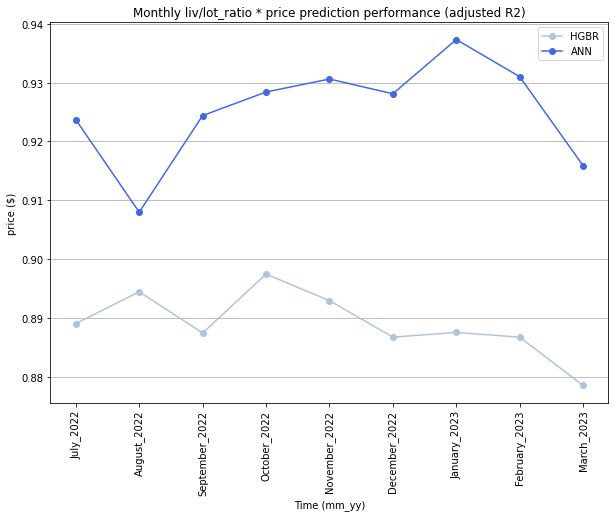

In [28]:
plt.figure(figsize = (10, 7))
plt.plot(df_hgbr['Test_adj_R_squared'], label = 'HGBR', marker = 'o', color = 'lightsteelblue')
plt.plot(df_ANN['Test_adj_R_squared'], label = 'ANN', marker = 'o', color = 'royalblue')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.xlabel('Time (mm_yy)')
plt.ylabel('price ($)')
plt.title('Monthly liv/lot_ratio * price prediction performance (adjusted R2)')
plt.grid(axis = 'y')
plt.show()

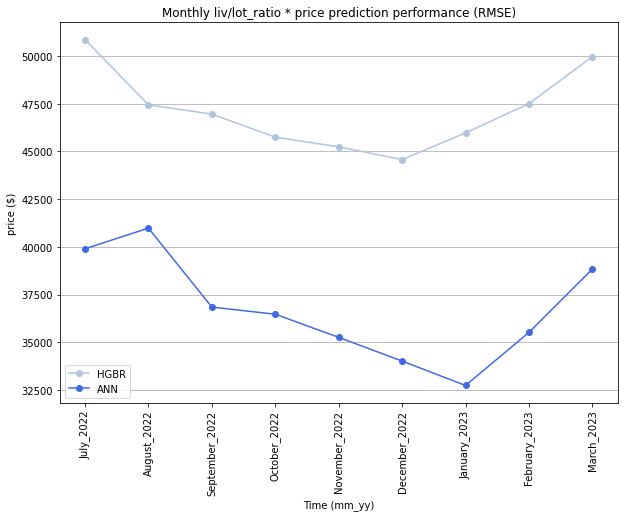

In [29]:
plt.figure(figsize = (10, 7))
plt.plot(df_hgbr['Test_RMSE'], label = 'HGBR', marker = 'o', color = 'lightsteelblue')
plt.plot(df_ANN['Test_RMSE'], label = 'ANN', marker = 'o', color = 'royalblue')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.xlabel('Time (mm_yy)')
plt.ylabel('price ($)')
plt.title('Monthly liv/lot_ratio * price prediction performance (RMSE)')
plt.grid(axis = 'y')
plt.show()

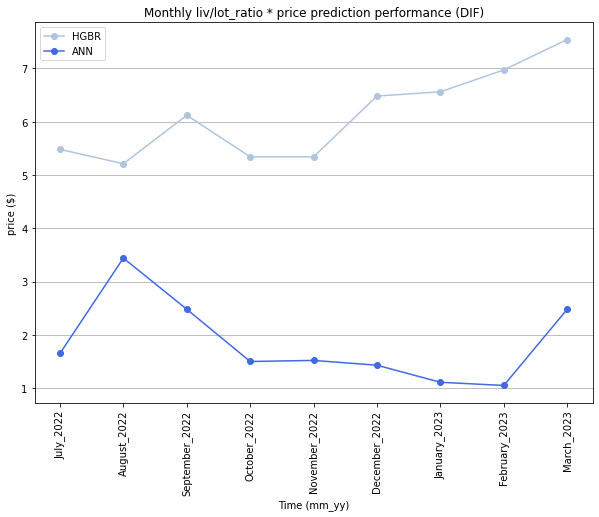

In [30]:
plt.figure(figsize = (10, 7))
plt.plot(abs(df_hgbr['DIF']), label = 'HGBR', marker = 'o', color = 'lightsteelblue')
plt.plot(abs(df_ANN['DIF']), label = 'ANN', marker = 'o', color = 'royalblue')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.xlabel('Time (mm_yy)')
plt.ylabel('price ($)')
plt.title('Monthly liv/lot_ratio * price prediction performance (DIF)')
plt.grid(axis = 'y')
plt.show()